In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
passengers_df = pd.read_csv('df_passengers.csv')

In [3]:
# Below steps are similar to what has been done during EDA to ensure dataset is correctly formatted for subsequent modelling.
passengers_df['Date'] = pd.to_datetime(passengers_df.Date, format="%d/%m/%Y", errors='coerce')
print(passengers_df.dtypes)

Date                        datetime64[ns]
total_passengers                     int64
total_passengers_arr                 int64
total_passengers_dep                 int64
total_passengers_transit             int64
dtype: object


In [4]:
passengers_df = passengers_df.set_index("Date")
passengers_df

,total_passengers,total_passengers_arr,total_passengers_dep,total_passengers_transit
Date,,,,
2025-02-01,5441857,2754111,2645524,42222
2025-01-01,6155064,3130805,2971086,53173
2024-12-01,6410825,3218469,3144724,47632
2024-11-01,5741007,2839182,2855880,45945
2024-10-01,5650043,2757008,2840028,53007
...,...,...,...,...
1980-05-01,587003,246876,257562,82565
1980-04-01,561218,240343,246241,74634
1980-03-01,597644,246262,254054,97328


In [5]:
# Filtering to data from Jan 1989 only
passengers_df = passengers_df.loc['1989-01-01':]
passengers_df.sort_values("Date", inplace=True)
passengers_df

,total_passengers,total_passengers_arr,total_passengers_dep,total_passengers_transit
Date,,,,
1989-01-01,1107283,503277,506179,97827
1989-02-01,1050398,479227,488700,82471
1989-03-01,1160644,531121,538332,91191
1989-04-01,1089718,493376,505403,90939
1989-05-01,1100198,499419,516145,84634
...,...,...,...,...
2024-10-01,5650043,2757008,2840028,53007
2024-11-01,5741007,2839182,2855880,45945
2024-12-01,6410825,3218469,3144724,47632


## Auto-ARIMA

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# To prevent COVID-19 figures from affecting the model, we will use data up till Dec 2019 for modelling.
p2019_df = passengers_df.loc['1989-01-01':'2019-12-01']
p2019_df

,total_passengers,total_passengers_arr,total_passengers_dep,total_passengers_transit
Date,,,,
1989-01-01,1107283,503277,506179,97827
1989-02-01,1050398,479227,488700,82471
1989-03-01,1160644,531121,538332,91191
1989-04-01,1089718,493376,505403,90939
1989-05-01,1100198,499419,516145,84634
...,...,...,...,...
2019-08-01,5900629,2926617,2911530,62482
2019-09-01,5469342,2726048,2682724,60570
2019-10-01,5646643,2787094,2801262,58287


In [8]:
import pmdarima as pm # to do Auto ARIMA
from pmdarima.arima import ADFTest # to perform ADF test 

In [9]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(p2019_df['total_passengers']) 

(0.9252193893119155, True)

#### Inference:
Null hypothesis: time series data is not stationary
Alternate hypothesis: time series data is stationary
- p=0.925, hence, we will not reject null hypothesis based on statistical proof. This is means our time series data is not stationary and differencing is needed

In [10]:
# Train-test split of time series data
y_train, y_test = train_test_split(p2019_df['total_passengers'], test_size=.1, shuffle=False)

In [12]:
arima_model = pm.AutoARIMA(start_p=12, max_p=36, 
                           d=None,    # find optimum value of d automatically
                           start_q=12, max_q=36, 
                           trace=True, # Print values in console for each fit in the grid search
                           random_state=20, # repeatability of steps in the same order
                           n_fits=50 # max no. of ARIMA models fits, the algorithm MUST stop at the end of 50 fits
                          )

arima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(12,1,12)(0,0,0)[0] intercept   : AIC=8842.833, Time=11.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9163.586, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9149.565, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9112.608, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9162.365, Time=0.14 sec
 ARIMA(11,1,12)(0,0,0)[0] intercept   : AIC=inf, Time=11.42 sec
 ARIMA(12,1,11)(0,0,0)[0] intercept   : AIC=8843.475, Time=11.79 sec
 ARIMA(13,1,12)(0,0,0)[0] intercept   : AIC=inf, Time=14.19 sec
 ARIMA(12,1,13)(0,0,0)[0] intercept   : AIC=inf, Time=15.01 sec
 ARIMA(11,1,11)(0,0,0)[0] intercept   : AIC=8846.608, Time=10.20 sec
 ARIMA(11,1,13)(0,0,0)[0] intercept   : AIC=inf, Time=10.95 sec
 ARIMA(13,1,11)(0,0,0)[0] intercept   : AIC=8852.999, Time=14.23 sec
 ARIMA(13,1,13)(0,0,0)[0] intercept   : AIC=inf, Time=15.48 sec
 ARIMA(12,1,12)(0,0,0)[0]             : AIC=inf, Time=11.43 sec

Best model:  ARIMA(12,1,12)(0,0,

AutoARIMA(max_p=36, max_q=36, n_fits=50, random_state=20, start_p=12,
          start_q=12, trace=True)

#### Inference:
Based on all the combinations checked, **ARIMA(12,1,12) p=12, d=1 and q=12** is the most optimal (i.e. lowest possible AIC score; estimator of out-of-sample prediction error).

In [13]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  334
Model:             SARIMAX(12, 1, 12)   Log Likelihood               -4395.417
Date:                Tue, 15 Apr 2025   AIC                           8842.833
Time:                        20:33:15   BIC                           8941.845
Sample:                    01-01-1989   HQIC                          8882.315
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.417e+04   1.42e+04      1.704      0.088   -3634.801     5.2e+04
ar.L1         -0.1912      0.123     -1.556      0.120      -0.432       0.050
ar.L2         -0.2115      0.128     -1.648      0.099      -0.463       0.040
ar.L3         -0.1571      0.146     -1.078      0.281      -0.443       0.129
ar.L4         -0.1398      0.136     -1.027      0.304      -0.407       0.127
ar.L5         -0.1150      0.139     -0.830      0.407      -0.387       0.157
ar.L6         -0.1308      0.120     -1.092      0.275      -0.366       0.104
ar.L7         -0.1055      0.114     -0.923      0.356      -0.330       0.119
ar.L8         -0.1495      0.098     -1.521      0.128      -0.342       0.043
ar.L9         -0.1424      0.096     -1.491      0.136      -0.330       0.045
ar.L10        -0.1799      0.078     -2.318      0.020      -0.332      -0.028
ar.L11        -0.1864      0.089     -2.100      0.036      -0.360      -0.012
ar.L12         0.7536      0.091      8.300      0.000       0.576       0.931
ma.L1         -0.0138      0.127     -0.109      0.913      -0.262       0.234
ma.L2          0.1309      0.113      1.160      0.246      -0.090       0.352
ma.L3         -0.1100      0.128     -0.858      0.391      -0.361       0.141
ma.L4          0.0095      0.114      0.084      0.933      -0.214       0.233
ma.L5         -0.0111      0.115     -0.097      0.923      -0.236       0.214
ma.L6          0.0686      0.111      0.619      0.536      -0.148       0.286
ma.L7         -0.0322      0.107     -0.302      0.763      -0.241       0.177
ma.L8          0.0800      0.112      0.714      0.475      -0.140       0.300
ma.L9          0.0621      0.094      0.660      0.509      -0.122       0.247
ma.L10         0.0134      0.085      0.158      0.875      -0.153       0.179
ma.L11         0.1289      0.091      1.423      0.155      -0.049       0.306
ma.L12        -0.6694      0.079     -8.465      0.000      -0.824      -0.514
sigma2      1.558e+10        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              2243.09
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -1.88
Prob(H) (two-sided):                  0.71   Kurtosis:                        15.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.55e+36. Standard errors may be unstable.
"""

In [14]:
# Making predictions using the ARIMA model we have identified
y_pred = arima_model.predict(n_periods = len(y_test)) # we want as many future predictions as there are in y_test
y_pred

2016-11-01    4.778472e+06
2016-12-01    5.365404e+06
2017-01-01    4.913501e+06
2017-02-01    4.632691e+06
2017-03-01    4.979990e+06
2017-04-01    4.882554e+06
2017-05-01    4.899457e+06
2017-06-01    5.029899e+06
2017-07-01    5.183307e+06
2017-08-01    5.042716e+06
2017-09-01    4.783475e+06
2017-10-01    4.928550e+06
2017-11-01    4.940666e+06
2017-12-01    5.497860e+06
2018-01-01    5.069434e+06
2018-02-01    4.786744e+06
2018-03-01    5.133724e+06
2018-04-01    5.046863e+06
2018-05-01    5.057197e+06
2018-06-01    5.168113e+06
2018-07-01    5.329763e+06
2018-08-01    5.183600e+06
2018-09-01    4.937191e+06
2018-10-01    5.082174e+06
2018-11-01    5.096885e+06
2018-12-01    5.626683e+06
2019-01-01    5.220363e+06
2019-02-01    4.937827e+06
2019-03-01    5.283481e+06
2019-04-01    5.207923e+06
2019-05-01    5.212165e+06
2019-06-01    5.305746e+06
2019-07-01    5.474957e+06
2019-08-01    5.325344e+06
2019-09-01    5.090245e+06
2019-10-01    5.235596e+06
2019-11-01    5.252191e+06
2

In [15]:
y_test

Date
2016-11-01    4784818
2016-12-01    5676648
2017-01-01    5256301
2017-02-01    4669729
2017-03-01    5112576
2017-04-01    5168548
2017-05-01    5003578
2017-06-01    5208779
2017-07-01    5415734
2017-08-01    5265703
2017-09-01    4927561
2017-10-01    5155327
2017-11-01    5173747
2017-12-01    5861990
2018-01-01    5303639
2018-02-01    4932345
2018-03-01    5555117
2018-04-01    5430745
2018-05-01    5294980
2018-06-01    5565775
2018-07-01    5723094
2018-08-01    5682688
2018-09-01    5225903
2018-10-01    5376234
2018-11-01    5408993
2018-12-01    6127843
2019-01-01    5656076
2019-02-01    5131807
2019-03-01    5630780
2019-04-01    5580503
2019-05-01    5407308
2019-06-01    5816089
2019-07-01    5910782
2019-08-01    5900629
2019-09-01    5469342
2019-10-01    5646643
2019-11-01    5718386
2019-12-01    6414495
Name: total_passengers, dtype: int64

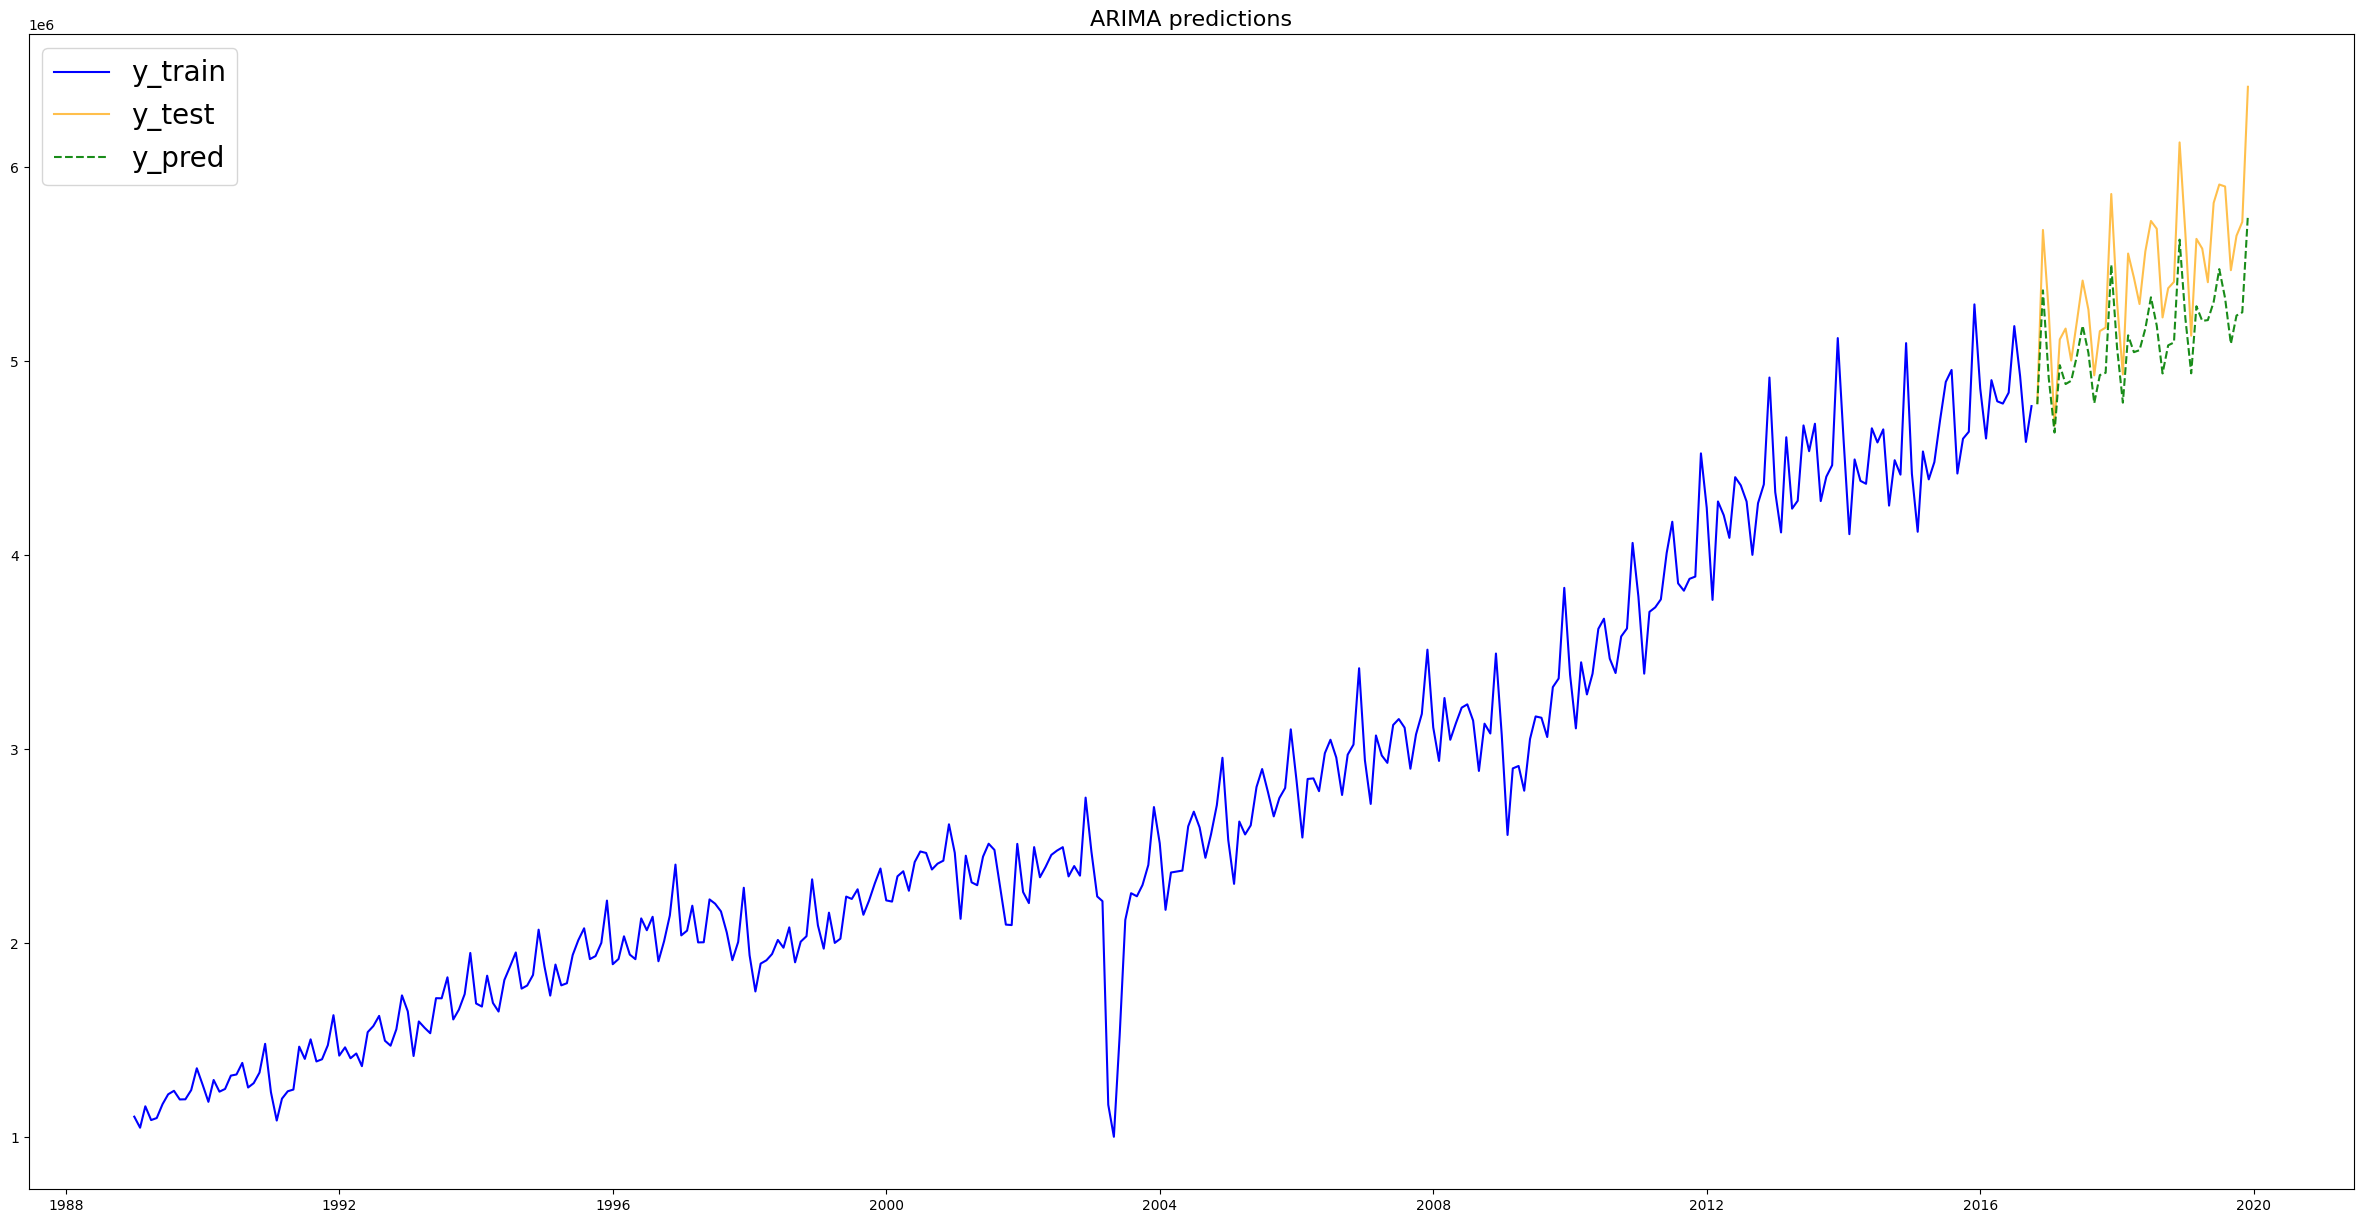

In [16]:
# Make a plot to compare y_pred vs y_test
plt.figure(figsize=(30,15))

plt.plot(y_train, color='blue', label='y_train')
plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)
plt.plot(y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')

plt.title(label = 'ARIMA predictions', fontsize=16)
plt.legend(fontsize = 20, loc = 'upper left');

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

In [18]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

0.05627829365784263

In [20]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_test, y_pred)
rmse

345218.43833691167

#### Intepretation:
- Auto-ARIMA seemed to be able to mimic the y-test rather closely, as seen from the plot above.
- Based on MAPE: 5.6%, there is approx 6% chance of error on average for the predictions made.
- On average, predictions are off by about 345,000 passengers, with larger errors weighted more heavily. 

## SARIMA

In [23]:
# import ACF plot from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

In [24]:
# diff() gets delta between every month vs previous month - achieves stationarity
y_train.diff().head()

Date
1989-01-01         NaN
1989-02-01    -56885.0
1989-03-01    110246.0
1989-04-01    -70926.0
1989-05-01     10480.0
Name: total_passengers, dtype: float64

In [25]:
# drop null from 1st month with dropna()
y_train.diff().dropna().head()

Date
1989-02-01    -56885.0
1989-03-01    110246.0
1989-04-01    -70926.0
1989-05-01     10480.0
1989-06-01     71491.0
Name: total_passengers, dtype: float64

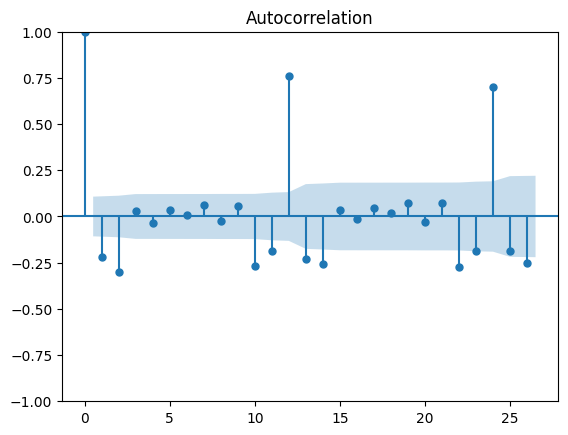

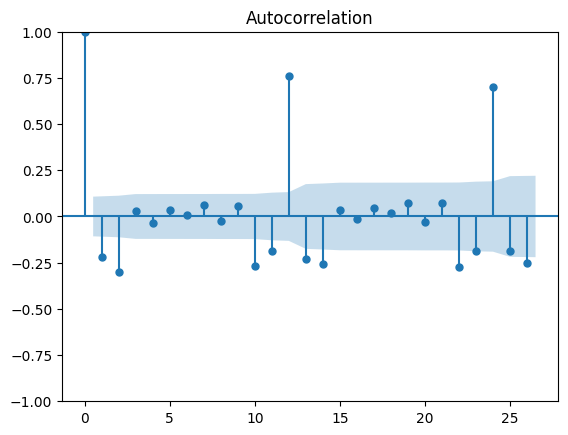

In [27]:
# Generate autocorrelation plot on training data.
plot_acf(y_train.diff().dropna())

#### Inference:
- Every data point's correlation between itself and all previous data points (lags) are checked
- 1st correlation coefficient is `1` --> this is the data point's correlation with itself, hence, it shows perfect correlation
- The points are correlation coefficients of different lags in the data
- There is a spike in the correlation coefficient (in the positive value) every 12 steps. Hence, the seasonality parameter S = 12.

In [28]:
# same parameters as Auto ARIMA for p,d,q
sarima_model = pm.AutoARIMA(
                           start_p=12, max_p=36, 
                           d=None,    
                           start_q=12, max_q=36, 
                                                     
                           start_P=12, max_P=36, 
                           D=None,    
                           start_Q=12, max_Q=36,
                           m=12,
                           seasonal=True,
                           
                           trace=True, 
                           random_state=20,
                           n_fits=50
                          )

sarima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(11,1,11)(12,0,12)[12] intercept   : AIC=inf, Time=617.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9163.586, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8979.861, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9032.749, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9162.365, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=9149.565, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=8966.976, Time=0.66 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=8965.802, Time=1.57 sec
 ARIMA(1,1,0)(4,0,0)[12] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=8967.513, Time=3.05 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=8966.795, Time=0.92 sec
 ARIMA(1,1,0)(4,0,1)[12] intercept   : AIC=8967.283, Time=3.58 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=8973.464, Time=1.42 sec
 ARIMA(2,1,0)(3,0,0)[12] intercept   : AIC=8941.038, Time=2.44 sec
 ARIMA(2,1,0)(2,0,0)[12

AutoARIMA(m=12, max_P=36, max_Q=36, max_p=36, max_q=36, n_fits=50,
          random_state=20, start_P=12, start_Q=12, start_p=12, start_q=12,
          trace=True)

#### Inferences:
In ARIMA(5,1,0)(1,0,1)[12]: `p`,`d`,`q`: (5,1,0) | `P`,`D`,`Q`: (1,0,1) | `S`/`m`: 12

In [29]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  334
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -4449.814
Date:                              Tue, 15 Apr 2025   AIC                           8915.627
Time:                                      21:46:10   BIC                           8946.092
Sample:                                  01-01-1989   HQIC                          8927.775
                                       - 10-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1379      0.079     -1.735      0.083      -0.294       0.018
ar.L2         -0.1534      0.107     -1.432      0.152      -0.363       0.056
ar.L3         -0.1437      0.082     -1.755      0.079      -0.304       0.017
ar.L4         -0.1446      0.109     -1.331      0.183      -0.357       0.068
ar.L5         -0.0881      0.118     -0.748      0.454      -0.319       0.143
ar.S.L12       0.9456      0.042     22.296      0.000       0.862       1.029
ma.S.L12      -0.6743      0.111     -6.101      0.000      -0.891      -0.458
sigma2      4.007e+10   1.59e-12   2.52e+22      0.000    4.01e+10    4.01e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1673.13
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -1.76
Prob(H) (two-sided):                  0.19   Kurtosis:                        13.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+37. Standard errors may be unstable.
"""

In [30]:
y_pred = sarima_model.predict(n_periods = len(y_test))
y_pred

2016-11-01    4.795596e+06
2016-12-01    5.317771e+06
2017-01-01    4.926900e+06
2017-02-01    4.652194e+06
2017-03-01    4.955459e+06
2017-04-01    4.839471e+06
2017-05-01    4.848584e+06
2017-06-01    5.015595e+06
2017-07-01    5.135782e+06
2017-08-01    5.073877e+06
2017-09-01    4.775085e+06
2017-10-01    4.929233e+06
2017-11-01    4.947266e+06
2017-12-01    5.433697e+06
2018-01-01    5.049974e+06
2018-02-01    4.795354e+06
2018-03-01    5.087456e+06
2018-04-01    4.979977e+06
2018-05-01    4.989421e+06
2018-06-01    5.146626e+06
2018-07-01    5.258704e+06
2018-08-01    5.199587e+06
2018-09-01    4.917167e+06
2018-10-01    5.063255e+06
2018-11-01    5.080618e+06
2018-12-01    5.540687e+06
2019-01-01    5.177773e+06
2019-02-01    4.936903e+06
2019-03-01    5.213043e+06
2019-04-01    5.111406e+06
2019-05-01    5.120364e+06
2019-06-01    5.269042e+06
2019-07-01    5.375031e+06
2019-08-01    5.319129e+06
2019-09-01    5.052071e+06
2019-10-01    5.190201e+06
2019-11-01    5.206618e+06
2

In [31]:
y_test

Date
2016-11-01    4784818
2016-12-01    5676648
2017-01-01    5256301
2017-02-01    4669729
2017-03-01    5112576
2017-04-01    5168548
2017-05-01    5003578
2017-06-01    5208779
2017-07-01    5415734
2017-08-01    5265703
2017-09-01    4927561
2017-10-01    5155327
2017-11-01    5173747
2017-12-01    5861990
2018-01-01    5303639
2018-02-01    4932345
2018-03-01    5555117
2018-04-01    5430745
2018-05-01    5294980
2018-06-01    5565775
2018-07-01    5723094
2018-08-01    5682688
2018-09-01    5225903
2018-10-01    5376234
2018-11-01    5408993
2018-12-01    6127843
2019-01-01    5656076
2019-02-01    5131807
2019-03-01    5630780
2019-04-01    5580503
2019-05-01    5407308
2019-06-01    5816089
2019-07-01    5910782
2019-08-01    5900629
2019-09-01    5469342
2019-10-01    5646643
2019-11-01    5718386
2019-12-01    6414495
Name: total_passengers, dtype: int64

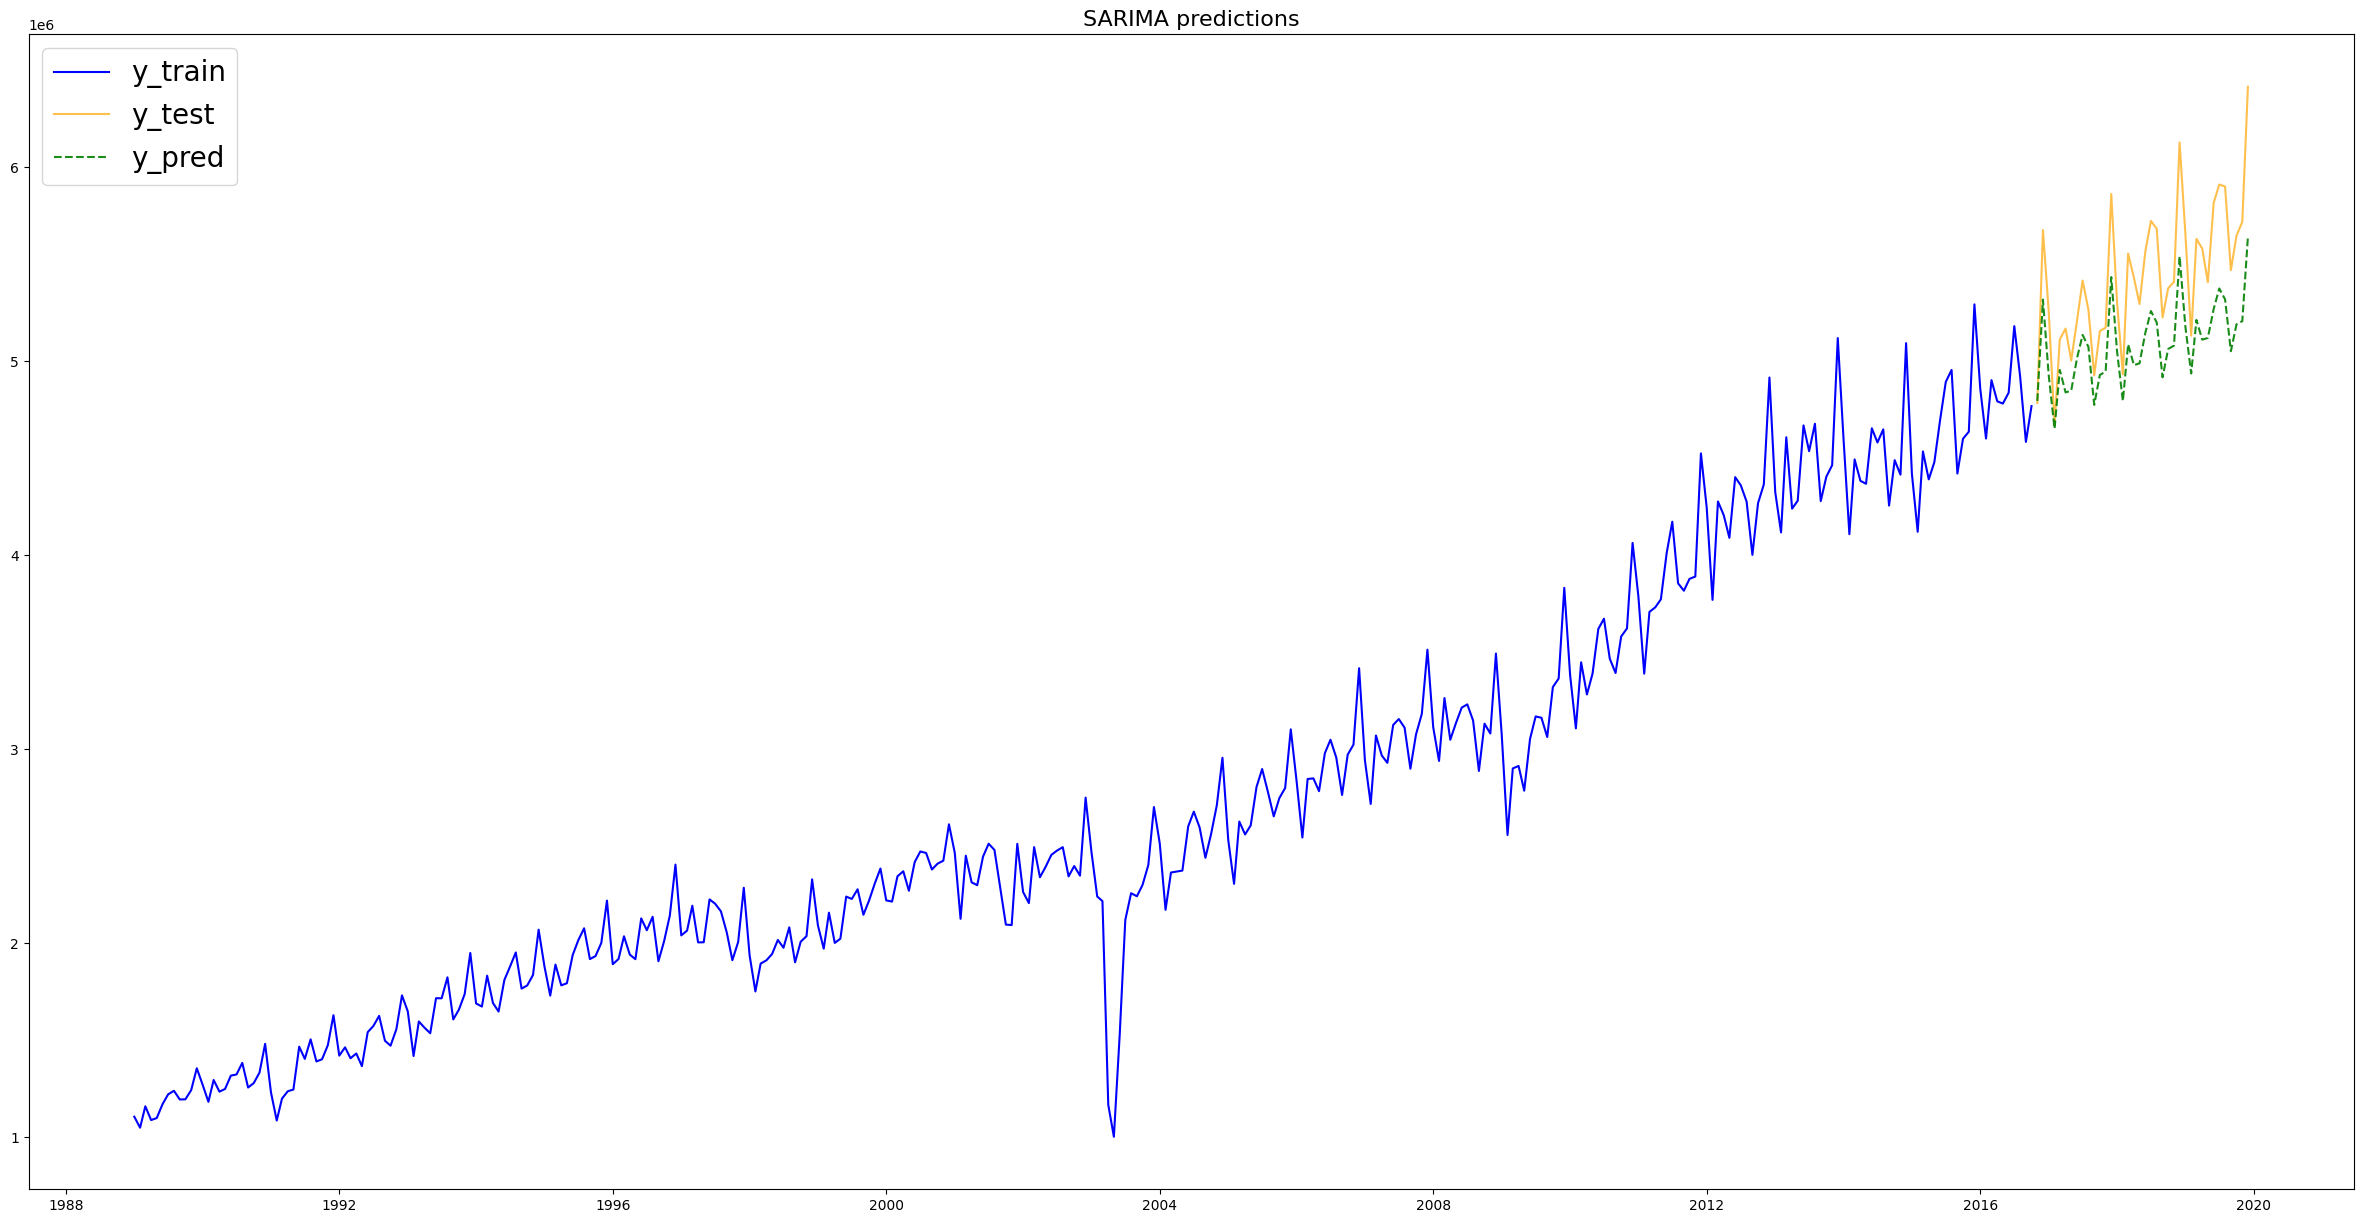

In [32]:
# Make a plot to compare y_pred vs y_test for SARIMA model
plt.figure(figsize=(30,15))

plt.plot(y_train, color='blue', label='y_train')
plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)
plt.plot(y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')

plt.title(label = 'SARIMA predictions', fontsize=16)
plt.legend(fontsize = 20, loc = 'upper left');

In [34]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print (f"SARIMA MAPE= {mape}")

rmse = root_mean_squared_error(y_test, y_pred)
print (f"SARIMA RMSE= {rmse}")

SARIMA MAPE= 0.062476657053220384
SARIMA RMSE= 385084.0230869068


#### Intepretation:
- SARIMA plot looks similar to the plot generated from Auto_ARIMA visually, with predicted values mimicking rather closely in terms of pattern to actual values.
- Based on MAPE: 6.2%, there is approx 6% chance of error on average for the predictions made => this is again very similar to what we obtained in our Auto-ARIMA model. However, the MAPE value is slightly higher with the SARIMA model vs Auto-ARIMA (0.0563), suggesting the Auto-ARIMA model is performing better in terms of predicting the true value.
- On average, predictions are off by about 385,000 passengers, which is again higher than Auto-ARIMA's model of 345,000 passengers.

## CONCLUSION: 
The **Auto-ARIMA model** i.e. *ARIMA(12,1,12) p=12, d=1 and q=12* which we obtained is the better model for predicting air passengers load of Changi Airport based on monthly passenger data from Jan 1989 to Dec 2019 used for training and testing.